In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

from qiskit.visualization import plot_histogram

Rozwiązanie książkowe dla dwóch kubitów (|00>)

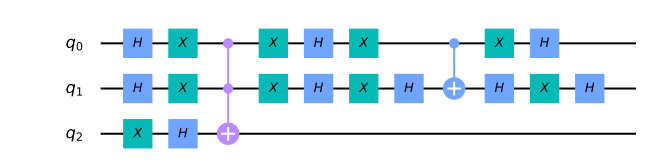

In [3]:
#przygotowanie układu
n = 3
grover_circuit = QuantumCircuit(n)

#inicjalizacja stanu
grover_circuit.x(2)

for qubit in range(n):
    grover_circuit.h(qubit)

#dodanie wyroczni
for qubit in range(n-1):
    grover_circuit.x(qubit)
grover_circuit.toffoli(0, 1, 2)
for qubit in range(n-1):
    grover_circuit.x(qubit)

#dodanie Hadamardów
for qubit in range(n-1):
    grover_circuit.h(qubit)

#dodanie inwersji
for qubit in range(n-1):
    grover_circuit.x(qubit)

grover_circuit.h(1)
grover_circuit.cx(0,1)
grover_circuit.h(1)

for qubit in range(n-1):
    grover_circuit.x(qubit)

#dodanie Hadamardów
for qubit in range(n-1):
    grover_circuit.h(qubit)

grover_circuit.draw('mpl')

Uruchamianie na symulatorze

<IPython.core.display.Math object>

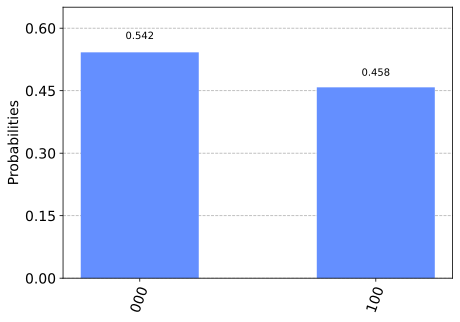

In [4]:
backend_sim = Aer.get_backend('statevector_simulator')
job_sim = execute(grover_circuit, backend_sim)
statevec = job_sim.result().get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

grover_circuit.measure_all()

backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

Kubity są wyświetlane od ostatniego, więc pierwsze 2 mają 100% szansy na stan 00

Uruchamianie na prawdziwym urządzeniu

In [5]:
provider = IBMQ.load_account()
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

Running on current least busy device:  ibmq_burlington


Job Status: job has successfully run


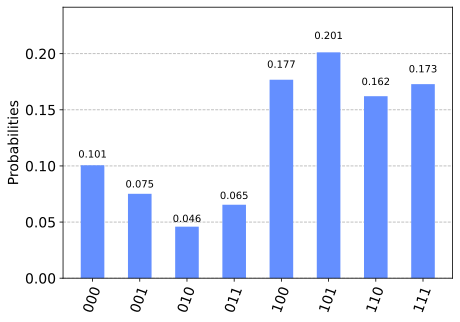

In [6]:
from qiskit.tools.monitor import job_monitor
job = execute(grover_circuit, backend=device, shots=1024, max_credits=10)
job_monitor(job, interval = 2)

results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

Jak widać największą szansę mają stany z dwoma 00 na końcu

Rozwiązanie z optymalizacjami

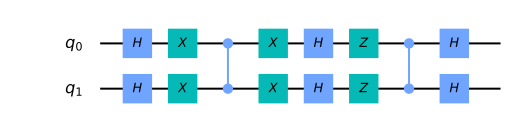

In [7]:
#przygotowanie układu
n = 2
grover_circuit2 = QuantumCircuit(n)

#inicjalizacja stanu
for qubit in range(n):
    grover_circuit2.h(qubit)

#dodanie wyroczni
for qubit in range(n):
    grover_circuit2.x(qubit)

grover_circuit2.cz(0, 1)

for qubit in range(n):
    grover_circuit2.x(qubit)

#dodanie Hadamardów
for qubit in range(n):
    grover_circuit2.h(qubit)

#dodanie inwersji
for qubit in range(n):
    grover_circuit2.z(qubit)
grover_circuit2.cz(0, 1)

#dodanie Hadamardów
for qubit in range(n):
    grover_circuit2.h(qubit)

grover_circuit2.draw('mpl')

Uruchamianie na symulatorze

<IPython.core.display.Math object>

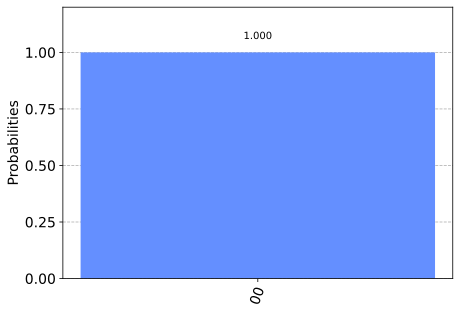

In [8]:
backend_sim = Aer.get_backend('statevector_simulator')
job_sim = execute(grover_circuit2, backend_sim)
statevec = job_sim.result().get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

grover_circuit2.measure_all()

backend = Aer.get_backend('qasm_simulator')
shots = 1024
results2 = execute(grover_circuit2, backend=backend, shots=shots).result()
answer2 = results2.get_counts()
plot_histogram(answer2)

Uruchamianie na prawdziwym urządzeniu

In [9]:
provider = IBMQ.load_account()
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

ibmqfactory.load_account:WARNING:2020-06-06 15:37:19,290: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmq_london


Job Status: job has successfully run


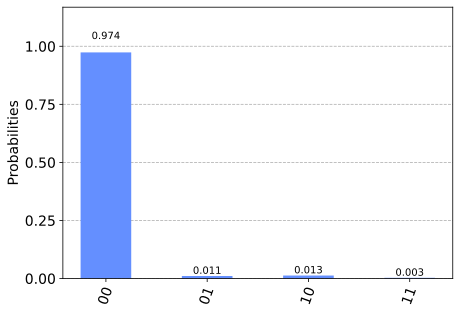

In [10]:
from qiskit.tools.monitor import job_monitor
job = execute(grover_circuit2, backend=device, shots=1024, max_credits=10)
job_monitor(job, interval = 2)

results2 = job.result()
answer2 = results2.get_counts(grover_circuit2)
plot_histogram(answer2)

Różnice wynikają z typowych dla prawdziwego urządzenia niedokładności obliczeń wynikających ze skończonej liczby prób i bazowania na prawdopodobieństwie.

Algorytm dla n = 3, korzystam z implementacji bazującej na https://qiskit.org/textbook/ch-algorithms/grover.html, szukamy dwóch liczb 101 i 110

In [11]:
#metody pomocnicze
def phase_oracle(circuit):
    circuit.cz(0, 2)
    circuit.cz(1, 2)
    
def diffuser(circuit):
    """Apply inversion about the average step of Grover's algorithm."""
    qubits = circuit.qubits
    nqubits = len(qubits)
    
    for q in range(nqubits):
        circuit.h(q)
        circuit.x(q)
    
    # Do controlled-Z
    circuit.h(2)
    circuit.ccx(0,1,2)
    circuit.h(2)
    
    for q in range(nqubits):
        circuit.x(q)
        circuit.h(q)

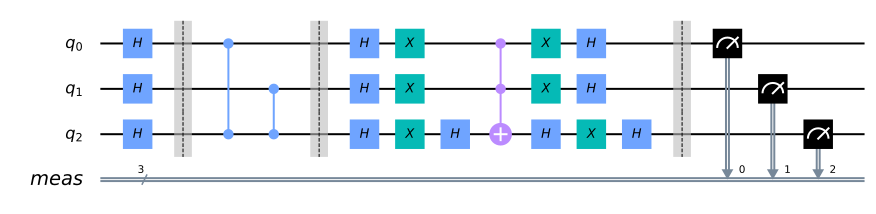

In [13]:
#przygotowanie układu
n = 3
barriers = True

grover_circuit3 = QuantumCircuit(n)

for qubit in range(n):
    grover_circuit3.h(qubit)
    
if barriers:
    grover_circuit3.barrier()

phase_oracle(grover_circuit3)

if barriers:
    grover_circuit3.barrier()

diffuser(grover_circuit3)

grover_circuit3.measure_all()

grover_circuit3.draw(output="mpl")

Uruchamianie na symulatorze

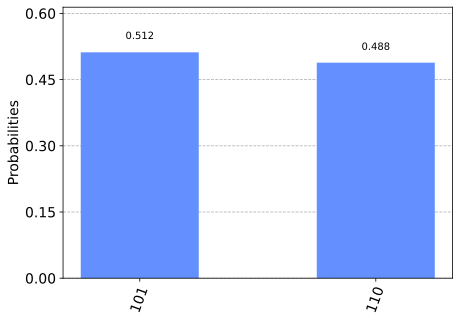

In [14]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit3, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

Otrzymane rezultaty są zgodne z oczekiwaniami
Dla lepszego zobrazowania sytuacji przedstawię teraz fragment algorytmu zakończony dodatkowymi Hadamardami w celu zbadania amplitud po otrzymaniu wyniku z wyroczni

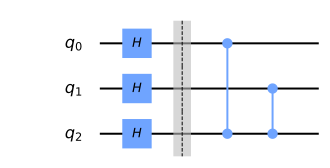

In [15]:
#przygotowanie układu
n = 3
barriers = True

grover_circuit4 = QuantumCircuit(n)

for qubit in range(n):
    grover_circuit4.h(qubit)
    
if barriers:
    grover_circuit4.barrier()

phase_oracle(grover_circuit4)

grover_circuit4.draw(output="mpl")

In [16]:
vector_sim = Aer.get_backend('statevector_simulator')
Aer.backends()
job = execute(grover_circuit4, vector_sim)
ket = job.result().get_statevector()
for amplitude in ket:
    print(amplitude)

(0.35355339059327384+0j)
(0.3535533905932738+0j)
(0.3535533905932738+0j)
(0.35355339059327373+0j)
(0.3535533905932738+0j)
(-0.35355339059327373+0j)
(-0.35355339059327373+0j)
(0.3535533905932737+0j)


Widać, że po opuszczeniu wyroczni amplitudy stanów których szukamy mają przeciwny znak

In [17]:
if barriers:
    grover_circuit4.barrier()

diffuser(grover_circuit4)

Teraz można zaobserwować sytuację po inwersji

In [18]:
vector_sim = Aer.get_backend('statevector_simulator')
Aer.backends()
job = execute(grover_circuit4, vector_sim)
ket = job.result().get_statevector()
for amplitude in ket:
    print(amplitude)

(-1.3877787807814462e-16+4.32978028117747e-17j)
(-1.1102230246251568e-16+2.465190328815662e-32j)
(-1.1102230246251568e-16-2.465190328815662e-32j)
(-8.32667268468867e-17-4.329780281177464e-17j)
(-3.260558063168959e-32-8.659560562354934e-17j)
(-0.7071067811865475+3.8968022530597194e-16j)
(-0.7071067811865475+3.8968022530597194e-16j)
(5.5511151231257796e-17-1.731912112470986e-16j)


Wszystkie amplitudy mają teraz ten sam znak, ale amplitudy szukanych stanów mają znacznie większą wartość bezwzględną.